In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from pprint import pprint
import sys
from colorama import Style, Fore
import warnings
import time 
import datetime as dt 
from glob import glob
from PIL import Image

warnings.filterwarnings(action = 'ignore')

rc = {
    "axes.facecolor": "#F6F6F6",
    "figure.facecolor": "#F6F6F6",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "malgun gothic",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)


red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

# **예매되지 않은 좌석들의 가격 추정하기**

* 추정하고자 하는 이유 
    
    * 익명성을 위해 공개되지 않은 공연 별 좌석 등급에 대해서 추정하여 원본 데이터일 것이라고 가정 후 분석하기 위함 
    * 가격 민감도 추정 및 좌석의 선호도를 구하기 위해서는 좌석 별 가격이 필수적으로 필요함

* 한계점

    * 현재 구해진 좌석들의 원가격은 추정치에 불과함
    * 할인 된 금액들을 가지고 계산하였기 때문에 추후 할인율을 역으로 계산하여 원가격을 추정 후 채워줘야함

# **기본 가정**

1. 좌석들의 등급 및 가격은 좌우 대칭적으로 측정되어 있다고 가정 
2. 좌석들의 등급 및 가격은 지역적 특성(좌석의 좌표)에 따라 지역적 상관관계를 가짐

In [2]:
file_path = "C:/Users/whileduck/Desktop/빈좌석"
pattern = '/*.csv'

full_path = file_path + pattern

file_list = glob(full_path)

dataframe_dict = {}

for file in file_list:
    
    key = file.split('\\')[1].split('_')[0] # key 저장
    
    dataframe_dict[key] = pd.read_csv(file, low_memory = False, encoding = 'utf-8')

print(dataframe_dict.keys())

dict_keys(['가족극', '교향곡', '기타', '독주', '복합장르', '성악', '실내악', '오페라', '재즈', '콘서트', '크로스오버', '클래식', '합창'])


In [3]:
df = dataframe_dict['클래식']

df.head()

,seat,X,Y,Z,예매여부,age,gender,membership_type_1,membership_type_2,membership_type_3,...,member_yn,공연연도,공연월,공연일,공연연월,전체공연시간,전체거래시간,층,석,세부좌석
0,1층 A블록1열 1,1451,542,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,1
1,1층 A블록1열 2,1406,555,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,2
2,1층 A블록1열 3,1361,568,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,3
3,1층 A블록1열 4,1315,580,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,4
4,1층 A블록1열 5,1270,591,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,5


In [4]:
# 가격 추정에 유의미한 변수 

print(df.columns)

columns = ['seat','X','Y','Z','전체공연시간','price'] # 전체 공연 시간 별 좌석의 원가격을 추정하고자 함 

Index(['seat', 'X', 'Y', 'Z', '예매여부', 'age', 'gender', 'membership_type_1',
       'membership_type_2', 'membership_type_3', 'membership_type_4',
       'membership_type_5', 'membership_type_6', 'tran_date', 'tran_time',
       'play_date', 'play_st_time', 'price', 'ticket_cancel', 'discount_type',
       'performance_code', 'pre_open_date', 'open_date', 'genre', 'place',
       'running_time', 'intermission', 'member_yn', '공연연도', '공연월', '공연일',
       '공연연월', '전체공연시간', '전체거래시간', '층', '석', '세부좌석'],
      dtype='object')


In [5]:

display(df.head())
print('좌석의 shape : ',df.shape)

,seat,X,Y,Z,예매여부,age,gender,membership_type_1,membership_type_2,membership_type_3,...,member_yn,공연연도,공연월,공연일,공연연월,전체공연시간,전체거래시간,층,석,세부좌석
0,1층 A블록1열 1,1451,542,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,1
1,1층 A블록1열 2,1406,555,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,2
2,1층 A블록1열 3,1361,568,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,3
3,1층 A블록1열 4,1315,580,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,4
4,1층 A블록1열 5,1270,591,-93,1,NaN,NaN,NaN,NaN,NaN,...,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1층,A블록1열,5


좌석의 shape :  (405810, 37)


* price 가 결측치인 경우 : 예매되지 않은 좌석
* price 가 0인 경우 : 초대권 등 금액을 지불하지 않은 좌석

원가격 추정을 위해서는 두 가지 경우 모두를 같은 결측치로 가정하고 추정해야 함 

하지만 만일 특정 공연에서 결측치가 너무 많아 학습이 불가능 할 것 같은 경우에는 학습의 어려움이 있어 해당 부분을 제외 해야 함 

코로나 때는 좌석 거리두기가 있었기 때문에 나눠서 데이터를 분석해보고 모델링해보자

이전 시각화해둔 자료를 보면 

콘서트홀 클래식 공연의 경우 2020-05-05 20:00:00 공연부터 2022-06-22 19:30:00 공연부터 거리두기를 시행 한 것으로 보임

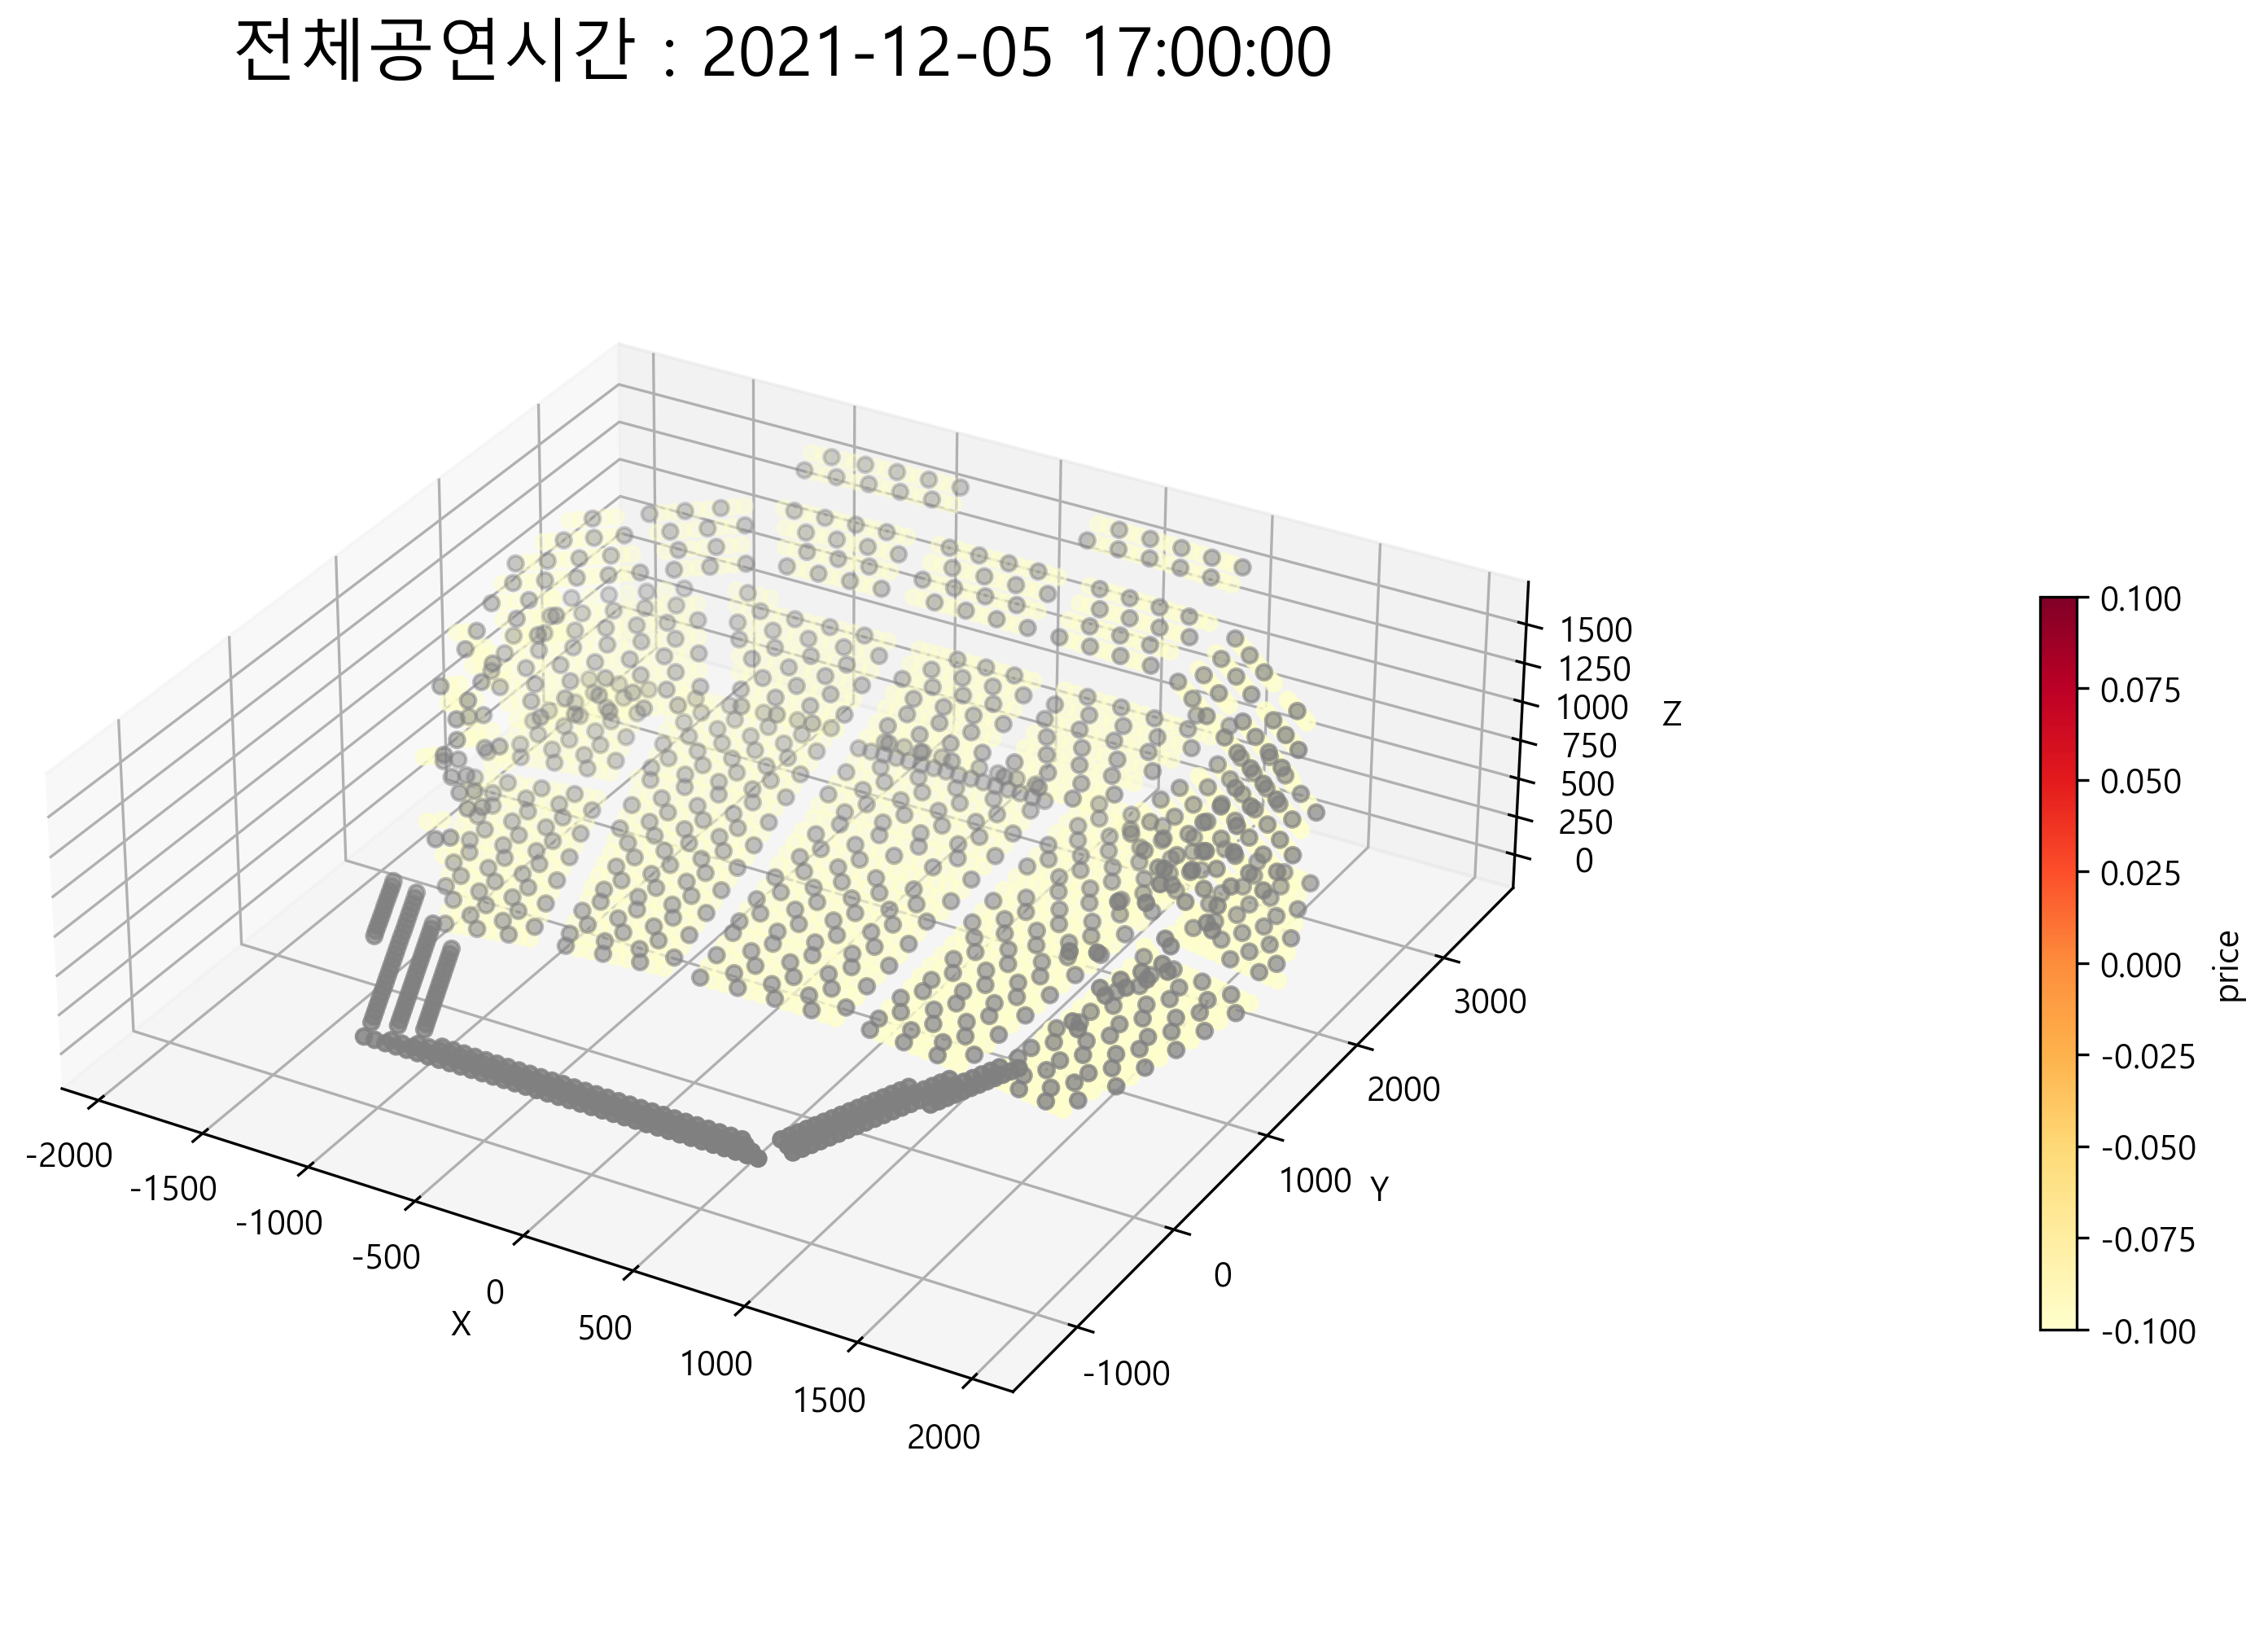

In [6]:
Image.open("C:/Users/whileduck/Desktop/total_price_image/전체공연시간_2021-12-05_17_00_00.png")

거리두기의 패턴을 가장 잘 볼 수 있는 사진으로 

한 블록의 한 열 당 3~4개씩의 좌석을 공석으로 비워둔 것으로 생각 할 수 있음 

추후 다른 노트북 파일에서 거리두기 기간과 거리두기 기간이 아닌 경우를 고려하여 예매율을 계산하도록 하자

In [7]:
def covid_divider(data):
    
    # 2020-05-05 20:00:00 공연부터 2022-06-22 19:30:00 코로나 기간
    
    start_date = '2020-05-05 20:00:00'
    end_date = '2022-06-22 19:30:00'
    
    data['전체공연시간'] = pd.to_datetime(data['전체공연시간']) 
    
    during_covid = data.loc[(data['전체공연시간'] >= start_date) & (data['전체공연시간'] <= end_date)]
    without_covid = data.loc[(data['전체공연시간'] < start_date) | (data['전체공연시간'] > end_date)]
    
    return during_covid,without_covid

In [8]:
# 추후 분석을 위해 따로 저장
during_covid , without_covid = covid_divider(df)

during_covid['좌석_오픈_여부'] = 1 
without_covid['좌석_오픈_여부'] = 1


file_path = 'C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/'

during_covid.to_csv(file_path + '코로나_기간_콘서트홀_클래식.csv',index = False)
without_covid.to_csv(file_path + '코로나_기간이후_콘서트홀_클래식.csv',index = False)

In [9]:
# covid 기간이 아닌 경우의 좌석 가격을 추정해보자

df  = without_covid.copy()

# **파이프라인**

1. 가격을 채울만큼의 구매량이 없는 경우에는 좌석 채우기를 하지 않거나 추후에 채우도록 함 
    
    1.1 얼만큼 이상이면 채우지 못할 것인가 ? 

2. 가격 및 등급이 좌 우로 대칭일 것이라 가정하고, 좌 우 중 어느 한 부분은 좌석이 예매가 되었고 어느 좌석은 예매가 되지 않은 경우 반대에 있는 경우의 금액으로 채우도록함 

3. 채우는 과정에서 추정된 가격일 경우를 알 수 있도록 추정된 가격인지 아닌지에 대해서 적도록 함 

In [28]:
class SeatImputation:
    
    def __init__(self,data):
        
        self.df = data